# Imports

In [56]:
import pandas as pd
import pandas_profiling
import numpy as np
from statsmodels.regression.linear_model import OLS, WLS
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from scipy.stats.stats import pearsonr
from scipy.stats import sem, t
from scipy import mean
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

def rainbow_test(model):
    alpha = .05
    fstat, p_value = linear_rainbow(model)
    print(f"fstat: {fstat}\np_value: {p_value}")
    if p_value < .05:
        print('This assumption is violated.')
    else:
        print('This assumption holds.')

def plot_residuals_fitted(model, data):
    '''
    Draw a scatterplot of fitted values against residuals, with a locally weighted scatterplot smoothing (lowess)
    regression line showing any apparent trend.
    '''
    resid = model.resid
    model_fitted_y = model.fittedvalues
    
    plot_lm_1 = plt.figure(1)
    plot_lm_1.set_figheight(8)
    plot_lm_1.set_figwidth(12)

    model_fitted_y = ols.fittedvalues
    # absolute residuals
    model_abs_resid = np.abs(resid)
    plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'OVALLSAT', 
                                      data=data, 
                                      lowess=True, 
                                      scatter_kws={'alpha': 0.5}, 
                                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals')

    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]

    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i, 
                                   xy=(model_fitted_y[i], 
                                       resid[i]))
        
def plot_scale_location(model):
    '''
    Plot a scatter plot of absolute square-rooted normalized residuals and fitted values, 
    with a lowess regression line. Use this to assess heteroskedasticity.
    '''
    resid = model.resid
    model_fitted_y = model.fittedvalues
    
    plot_lm_3 = plt.figure(3)
    plot_lm_3.set_figheight(8)
    plot_lm_3.set_figwidth(12)

    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(resid))

    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
                scatter=False, 
                ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

    for i in abs_sq_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i, 
                                   xy=(model_fitted_y[i], 
                                       model_norm_residuals_abs_sqrt[i]))
        
def plot_qq(model):
    '''
    Plot how well the distribution of residuals fit the normal distribution. This plots the standardized (z-score)
    residuals against the theoretical normal quantiles. Anything quite off the diagonal lines may be 
    a concern for further investigation.
    '''

    resid = model.resid
    QQ = ProbPlot(resid)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals')
    plot_lm_2.set_figheight(8)
    plot_lm_2.set_figwidth(12)
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(resid)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i,
                                   xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                       resid[i]))

In [57]:
df = pd.read_excel(r'data/ACQ360DataStacked_xlsx.xlsx')
df.head()

,ResponseID,Question,QuCode,QuCategory,QuTarget,QuType,Answer,Unnamed: 7
0,36,Last page,LastPg,Metadata,All,Autogenerated,2,NaN
1,36,Start language,StartLang,Metadata,All,Autogenerated,en,NaN
2,36,Date started,DateStarted,Metadata,All,Date,2016-06-07 15:46:10,NaN
3,36,Date last action,DateLastAction,Metadata,All,Date,2016-06-07 15:49:45,NaN
4,36,First 2 Characters of PIID,First2PIID,Attribute,All,Autogenerated,SS,NaN


In [3]:
#these are the questions whose responses will be IVs
cols = {'Were you part of an IPT (Integrated Procurement Team)-':'IPT_DUMMY',
        'Planning - How satisfied were you: [With the acquisition milestone schedule-]':'ACQMILE',
        'Planning - How satisfied were you: [With the procurement office’s ability to keep you informed of any changes to the acquisition milestone schedule-]':'SCHCHG',
        'Planning - How satisfied were you: [With the procurement office’s assistance in the Acquisition Plan process, which allowed you to better understand and participate in the procurement-]':'ACQASSIST',
        'Planning - How satisfied were you: [With the procurement office’s engagement with industry early in the acquisition process-]':'INDENG',
        'Communication - How satisfied were you: [With the procurement office’s responsiveness to your questions (communicating in a clear, courteous, timely, and professional manner)-]':'ACQCOM',
        'Communication - How satisfied were you: [With the procurement office’s effectiveness in resolving any issues or delays encountered during the acquisition process-]':'RESISS',
        'Communication - How satisfied were you: [With your understanding on how - and to whom – you should elevate problems for resolution-]':'ELEVPROB',
        'Communication - How satisfied were you: [With early communications describing the roles and responsibilities of the procurement office and of your office (program office)-]':'ACQRR',
        'Overall Satisfaction [How satisfied were you with your overall experience on this acquisition-]':'OVALLSAT'
        }

#filter for just the questions we're interested in
df = df[df['Question'].isin(cols)][['ResponseID','Question','Answer']]
df.head()

,ResponseID,Question,Answer
24,36,Were you part of an IPT (Integrated Procuremen...,NaN
62,71,Overall Satisfaction [How satisfied were you w...,5
64,71,Were you part of an IPT (Integrated Procuremen...,NaN
96,81,Overall Satisfaction [How satisfied were you w...,5
98,81,Were you part of an IPT (Integrated Procuremen...,NaN


In [4]:
#transform the data from long to wide, renaming columns to match names in EViews, treate a 
#dummy variable and create our design matrix
design_df = df.pivot(index = 'ResponseID', columns = 'Question', values = 'Answer').dropna()
design_df = design_df.rename(mapper = cols, axis = 1)
#make not being in an IPT the reference group
design_df['IPT_DUMMY'] = design_df['IPT_DUMMY'].map({'Yes':'yes', 'No':'no', 'No ':'no'})
design_df = design_df[cols.values()]
design_df.head()

Question,IPT_DUMMY,ACQMILE,SCHCHG,ACQASSIST,INDENG,ACQCOM,RESISS,ELEVPROB,ACQRR,OVALLSAT
ResponseID,,,,,,,,,,
103,yes,5,5,5,5,5,5,5,5,5
151,no,2,3,3,4,3,3,4,3,3
162,no,3,3,3,3,3,3,3,3,4
202,no,3,3,3,3,4,2,4,4,4
234,no,4,5,5,4,5,5,5,5,5


In [5]:
#ensure this dummy variable only contains yes and no
design_df['IPT_DUMMY'].value_counts()

no     135
yes     60
Name: IPT_DUMMY, dtype: int64

In [6]:
design_df[[x for x in design_df.columns if x != 'IPT_DUMMY']] = design_df[[x for x in design_df.columns if x != 'IPT_DUMMY']].astype(int)
#convert IPT_DUMMY to boolean
design_df['IPT_DUMMY'] = design_df.IPT_DUMMY == 'yes'
#get the number of ResponseIDs here for a future assertion
n_responses = len(design_df.index.unique())
design_df.index.name = None
design_df = design_df.reset_index()
design_df = design_df.drop(labels = 'index', axis = 1)
design_df.head()

Question,IPT_DUMMY,ACQMILE,SCHCHG,ACQASSIST,INDENG,ACQCOM,RESISS,ELEVPROB,ACQRR,OVALLSAT
0,True,5,5,5,5,5,5,5,5,5
1,False,2,3,3,4,3,3,4,3,3
2,False,3,3,3,3,3,3,3,3,4
3,False,3,3,3,3,4,2,4,4,4
4,False,4,5,5,4,5,5,5,5,5


In [7]:
design_df.isnull().sum()

Question
IPT_DUMMY    0
ACQMILE      0
SCHCHG       0
ACQASSIST    0
INDENG       0
ACQCOM       0
RESISS       0
ELEVPROB     0
ACQRR        0
OVALLSAT     0
dtype: int64

In [8]:
#ensure no dupe respondents
n_responses == design_df.shape[0]

True

# Exploratory Data Analysis
Summary stats for the variables.

In [9]:
pandas_profiling.ProfileReport(design_df)

Number of variables,10
Number of observations,195
Total Missing (%),0.0%
Total size in memory,14.0 KiB
Average record size in memory,73.4 B
Numeric,9
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,0


## Profile Takeaways
Since all of the variables are ordinal, an ordered logit model would be the most efficient estimator (although we'd need to be sure to inspect the proportional odds assumption).


Treating this as an OLS instead of MLE problem, a few issues stand out:

1. **None of the ordinal predictors have values of $0$.** This means we'll likely want to **center the data**, especially since we'll be using `IPT_DUMMY` as an interaction term. Centering won’t actually change what the model means, but it can make the results more interpretable. Namely, the intercept will show the average `OVALLSAT` for someone in the reference group (IPT==0) with average values for all the predictors. To center, we can subtract the mean of a column from that column (exlcuding the dependent variable and the categorical variable). We could subtract some other value, but the key is to have a score of $0$ on the IV correspond to something that is substantively
interesting, rather than have it be a value that could not (or at least does not) actually occur in the data. This [short read](https://www3.nd.edu/~rwilliam/stats2/l53.pdf) explains further.

2. **The predictors are all ordinal and not necessarily continuous.** Using OLS, we'll be making the assumption that there are "equal" intervals between the likert values in each IV.

3. **All of the predictors are left skewed, with high correlations.** As a result there are very high correlations between all pairwise combinations of predictors. This is problematic because highly correlated exogenous predictors can affect the stability of our coefficient estimates as we make minor changes to model specification (i.e. including and dropping independent variables). In other words, we have a multicollinearity issue.

4. **There are $102$ duplicate observations in this data set.** Duplicates can bias the estimated coefficients and standard errors, with the extent of this bias increasing with doublets, triplets, qunituplets, etc. Weighting the duplicate records by the inverse of their multiplicity, or dropping superfluous duplicates, could reduce the risk of obtaining biased estimates. However, this will likely overestimate standard errors, reducing the statistical power of the estimates. We *could* use a Monte Carlo simulation to investigate how various numbers and patterns of duplicate records affect the risk of obtaining biased estimates (c.f. [this](https://mpra.ub.uni-muenchen.de/69064/1/MPRA_paper_69064.pdf)), but this is likely overkill.

# OLS

The OLS model is going to have a dummy-encoded predictor (`IPT_DUMMY`), which will make the intercept the mean of `OVALLSAT` for the reference category (i.e. the category numbered 0, meaning not in an IPT). 

However, $0$ will not be a meaningful value for any predictor within the data set. As such, we need to center the data so that we can more easily interpret the intercept. We'll perform the analysis with and without centering to see the effect.

In [36]:
# note that a constant term is included by default
ols = smf.ols('OVALLSAT ~ center(SCHCHG) + center(ACQASSIST) + center(INDENG) + center(RESISS) \
               + center(ELEVPROB) + center(ACQRR) + center(ACQMILE)*IPT_DUMMY + center(ACQCOM)*IPT_DUMMY',
              data = design_df).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:               OVALLSAT   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     99.78
Date:                Tue, 14 May 2019   Prob (F-statistic):           3.57e-71
Time:                        12:57:24   Log-Likelihood:                -89.138
No. Observations:                 195   AIC:                             202.3
Df Residuals:                     183   BIC:                             241.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

## Interpretation

### `IPT_DUMMY` and Intercept

>Since we have the dummy variable `IPT_DUMMY` in the model, the `Intercept` of $4.3426$ tells us the mean value of `OVALLSAT` for the reference group (i.e. not being in an IPT) when all other predictors are their average value. 

>The mean value of `OVALLSAT` for the comparison group (being in an IPT) is the intercept ($4.3426$) plus the coefficient for `C(IPT_DUMMY)[T.1]` ($-0.0007$). But since the p-values are very high, we shouldn't put much stock in any deeper meanings. The result is basically looking at the following groupby result. So, instead, we'll look at the interactions.

In [37]:
design_df.groupby(by='IPT_DUMMY')['OVALLSAT'].mean()

IPT_DUMMY
False    4.362963
True     4.266667
Name: OVALLSAT, dtype: float64

### `IPT_DUMMY` Interactions
Since we have interactions, we are primarily interested in their significance, rather than the significance of the terms used to compute them. For example, looking at the `ACQMILE` coefficient alone only tells us about the difference between `IPT=1` and `IPT=0` at a specific point, i.e. when ACQMILE is its average value (`ACQMILE = 0` since we centered).

Looking at the interactins, we can see for `ACQMILE` that:

 - When IPT_DUMMY = 0, `ACQMILE` coefficient is -0.0374. 
 - When IPT_DUMMY = 1, `ACQMILE` coefficient is 0.1525 (-0.0374 + 0.1899)


Looking at the interactins, we can see for `ACQCOM` that:
 - When IPT_DUMMY = 0, `ACQCOM` coefficient is 0.3863
 - When IPT_DUMMY = 1, `ACQCOM` coefficient is 0.1694 (0.3863 + -0.2169)

# Weighted Least Squares
Due to the limitations identified with the OLS models above, particularly with the multicollinearity and also with some heteroskedasticity that was identified in post-hoc testing within EViews, it was decided to use weighted least squares to reduce the presence of both effects.

For the weighting series, the variance was purportedly determined to be proportional to `INDENG*INDENG` ($x$), so that $Var(y_{i}) = x_i\sigma^2$ and $w_i =1/ x_i$. This decision was also made due to `INDENG` having the highest variance inflation factor.

We'll fit this WLS model below (note that we're not centering the data).

In [74]:
#In statsmodels, the weights are presumed to be (proportional to) the inverse of the variance of the observations. 
#If you supply weights = 1./W then the variables are pre-multiplied by 1/sqrt(W)
#But Eviews assumes the weights to be proportional to the inverse of the standard deviation, so we use
#weights = 1./W**2
W = design_df['INDENG']*design_df['INDENG']

wls = smf.wls('OVALLSAT ~ SCHCHG + ACQASSIST + INDENG + RESISS \
               + ELEVPROB + ACQRR + ACQCOM*IPT_DUMMY + ACQMILE*IPT_DUMMY', 
              weights = 1./W**2,
              data = design_df).fit()
print(wls.summary())

                            WLS Regression Results                            
Dep. Variable:               OVALLSAT   R-squared:                       0.890
Model:                            WLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     134.6
Date:                Tue, 14 May 2019   Prob (F-statistic):           1.74e-81
Time:                        13:53:28   Log-Likelihood:                -324.95
No. Observations:                 195   AIC:                             673.9
Df Residuals:                     183   BIC:                             713.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

# WLS Diagnositcs

In order to deterimine if we have a **Best Linear Unbiased Estimator** (BLUE), we need to test the assumptions inherent to the Gauss–Markov theorem. To facilitate these tests, we'll make some diagnostic plots.

### Observed vs Predicted Values
We diagnose the extent of nonlinearity in our data by **plotting observed versus predicted values**. Here, the points should be symmetrically distributed around a diagonal line:

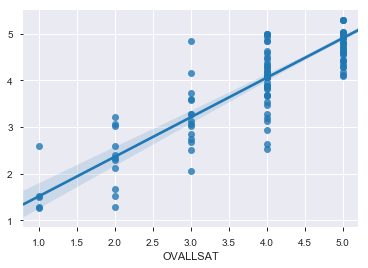

In [50]:
x = design_df['OVALLSAT']
y = wls.fittedvalues
regplot = sns.regplot(x,y)

Above, we can see that the points fall somewhat on a 45 degree line

### Residuals versus predicted values
This is a scatter plot of residuals on the y axis and fitted values (estimated responses) on the x axis. The plot is used to detect non-linearity, unequal error variances, and outliers.

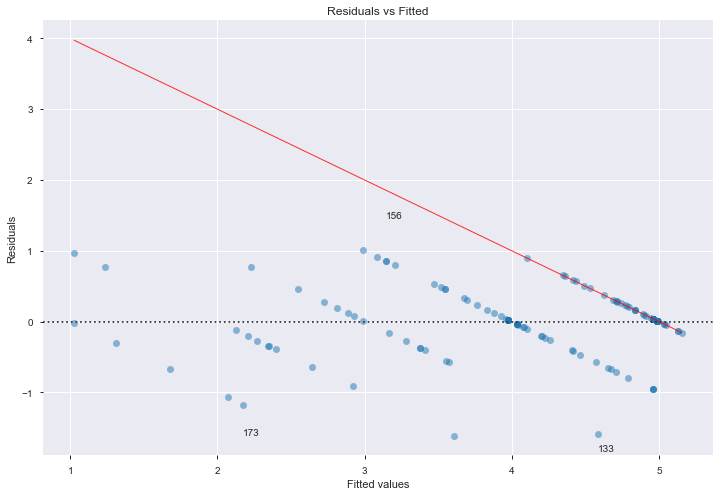

In [51]:
plot_residuals_fitted(wls, design_df)

Above, we can see that the residuals don't bounce randomly around the horizonal $0$ line. On the lefthand side of the graph, the points tend to fall under the horizontal line whereas on the righthand side of the graph they tend to fall above the horizontal line. This suggests that the assumption that the relationship is linear is not reasonable.

The residuals do, however, roughly form a "horizontal band" around the 0 line. This suggests that the variances of the error terms are equal.

Finnally, no single residual "stands out" from the basic pattern of residuals. This suggests that there are no outliers.

### Scale Location Plot

This plot shows if residuals are spread equally along the ranges of predictors. This is another way to check the assumption of equal variance (homoscedasticity). It’s good if you see a horizontal line with equally (randomly) spread points.

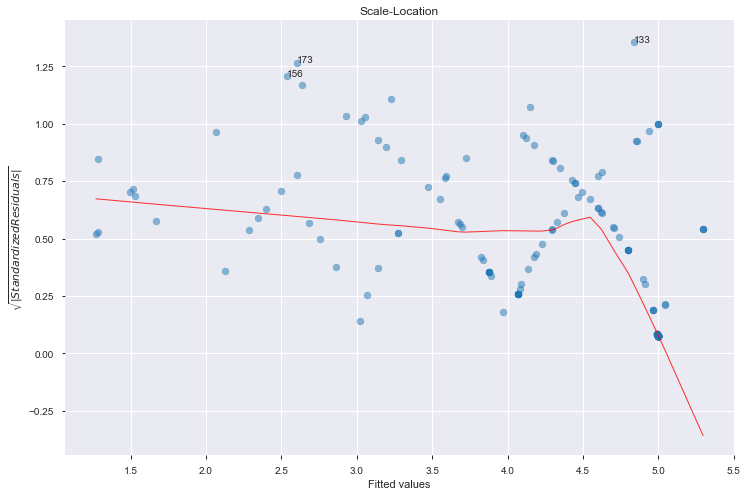

In [58]:
plot_scale_location(wls)

Above, we see that the residuals begin to spread wider along the x-axis as we passes around $4.5$, which is where the majority of the data falls. Thus we cannot say that the residuals are "identically and independently distributed".

### QQ Plot
This plots theoretical quantiles of a Gaussian vs observed values. If points approximately lie on the red line, then the errors are approximately Gaussian.

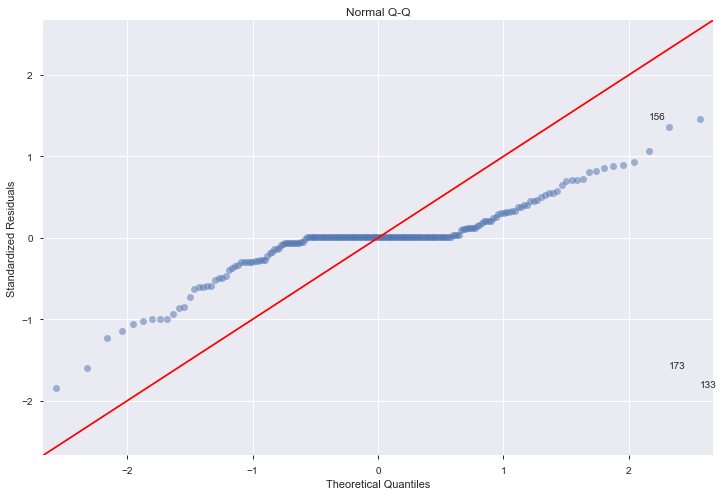

In [54]:
plot_qq(wls)

The fat tails tell us that the data is not necessarily Gaussian at the tails. We thus have to be careful if we implement a t-test to test whether elements of $\hat{\boldsymbol{\beta}}$ are non-zero, as our test statistic requires that $\hat{\beta}$ is Gaussian. 

Gaussian errors are good because they imply a Gaussian $\hat{\beta}$. Since we don’t have Gaussian residuals, we don’t have Gaussian errors, and so we need to see whether the central limit theorem can tell us that $\hat{\beta}$ is approximately Gaussian. We must investigate this carefully before concluding so. There are three common ways to deal with normality violations other than invoking the central limit theorem: 
1. transform either your features or your response 
2. fit a GLM instead of doing linear regression 
3. bootstrapping

### Partial Regression Plots
Since we are doing multivariate regression, we should also look at the relationship between the dependent variable and each independent variable conditional on the other independent variables. We can do this through using **partial regression plots**.

The `plot_regress_exog` function is a convenience function that gives a 2x2 plot containing the dependent variable and fitted values with confidence intervals vs. the independent variable chosen, the residuals of the model vs. the chosen independent variable, a partial regression plot, and a CCPR plot. This function can be used for quickly checking modeling assumptions with respect to a single regressor.

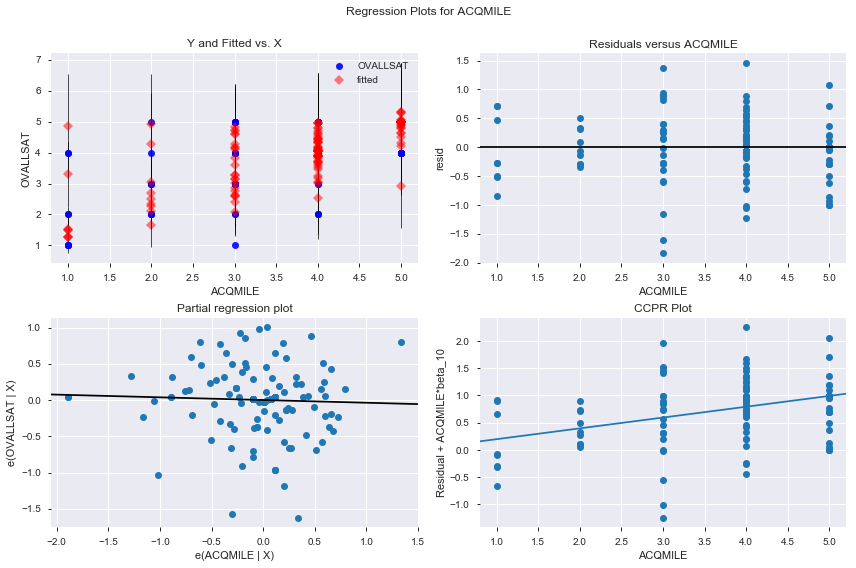

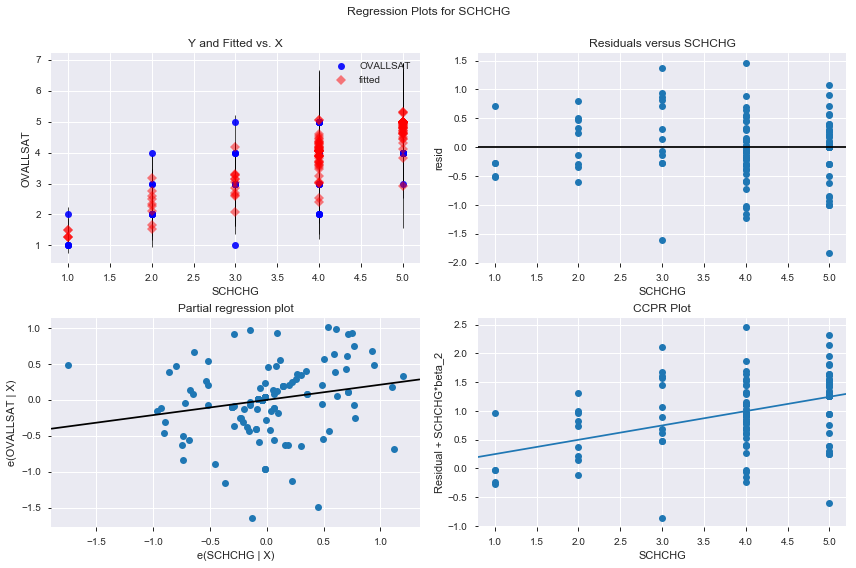

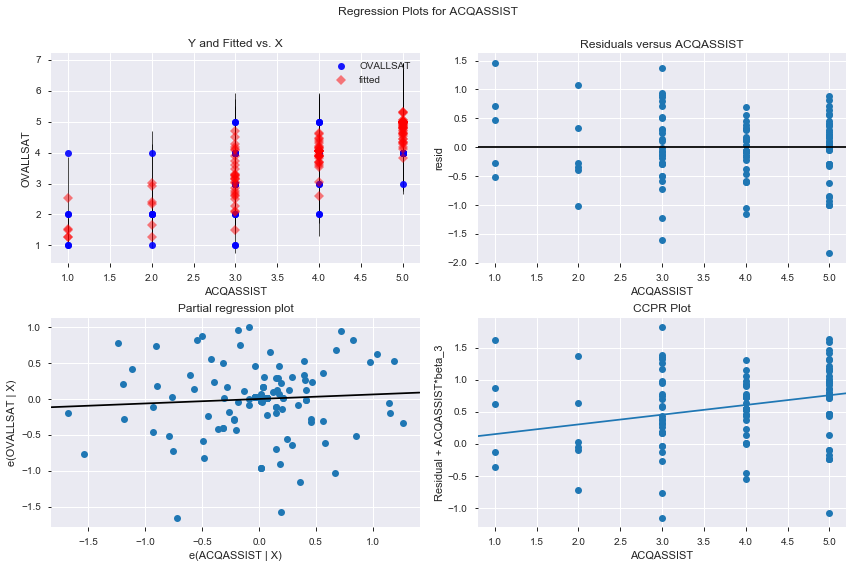

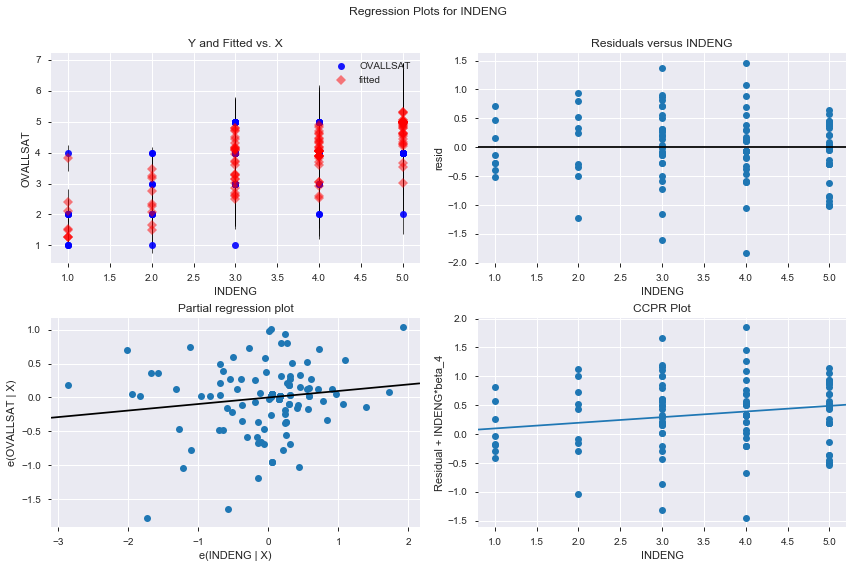

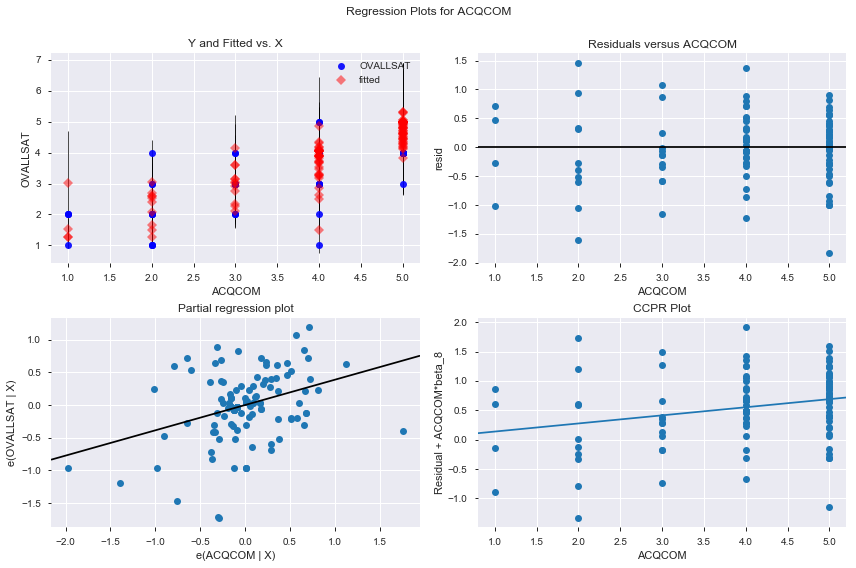

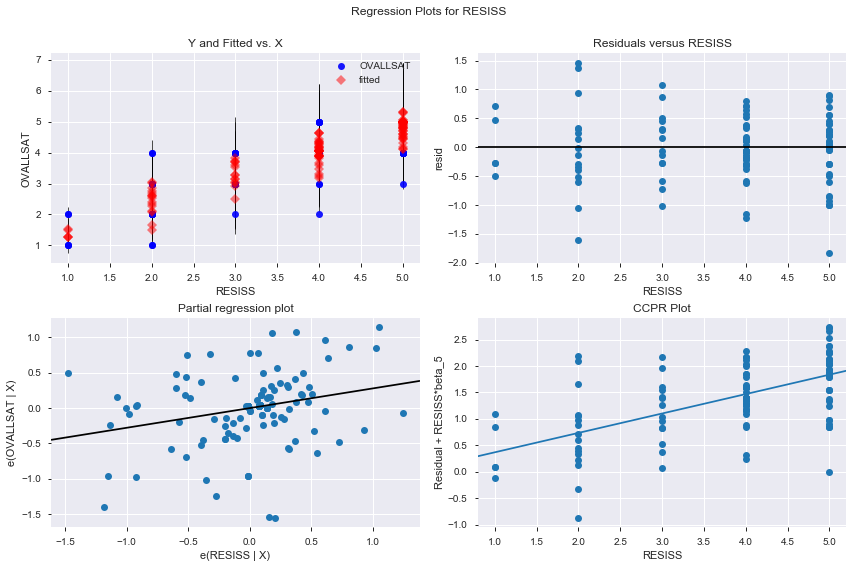

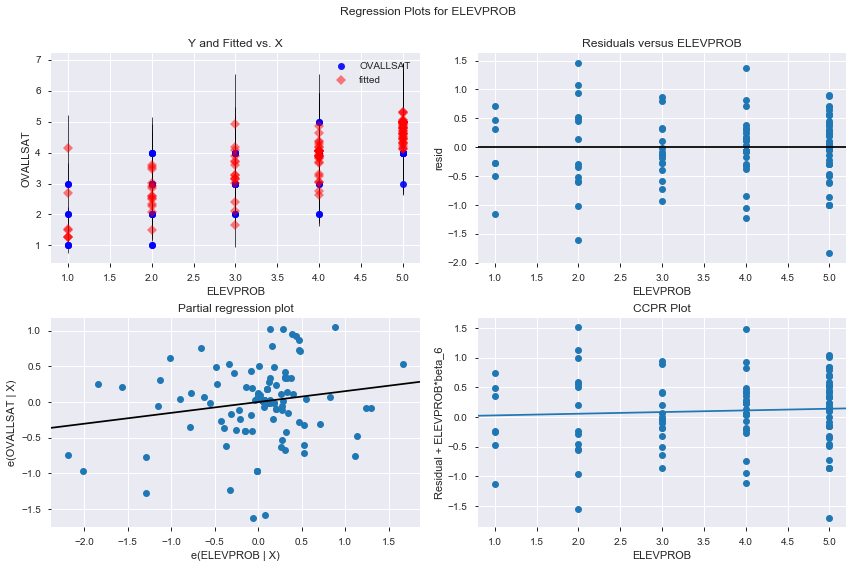

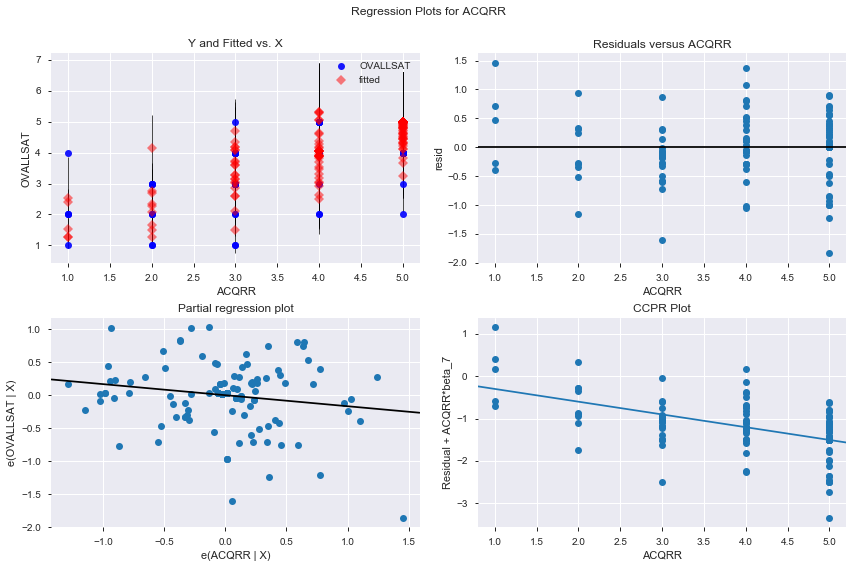

In [61]:
ivs = ['ACQMILE', 'SCHCHG', 'ACQASSIST', 'INDENG', 'ACQCOM', 'RESISS', 'ELEVPROB', 'ACQRR']
for iv in ivs:
    fig = plt.figure(figsize=(12,8))
    sm.graphics.plot_regress_exog(wls, iv, fig=fig)

#### Partial Regression Plots
In the partial regression plots, we can discern the relationship between the response variable and the $k^{th}$ variabe by computing the residuals when regressing the response variable versus the independent variables excluding $X_k$. We can denote this by $X_{\sim k}$. We then compute the residuals by regressing $X_k$ on $X_{\sim k}$. The partial regression plot is the plot of the former versus the latter residuals. 

The notable points of this plot are that the fitted line has slope $\beta_k$ and intercept zero. The residuals of this plot are the same as those of the least squares fit of the original model with full $X$. This allows us to discern the effects of the individual data values on the estimation of a coefficient easily. You can also see the violation of underlying assumptions such as homoskedasticity and linearity.

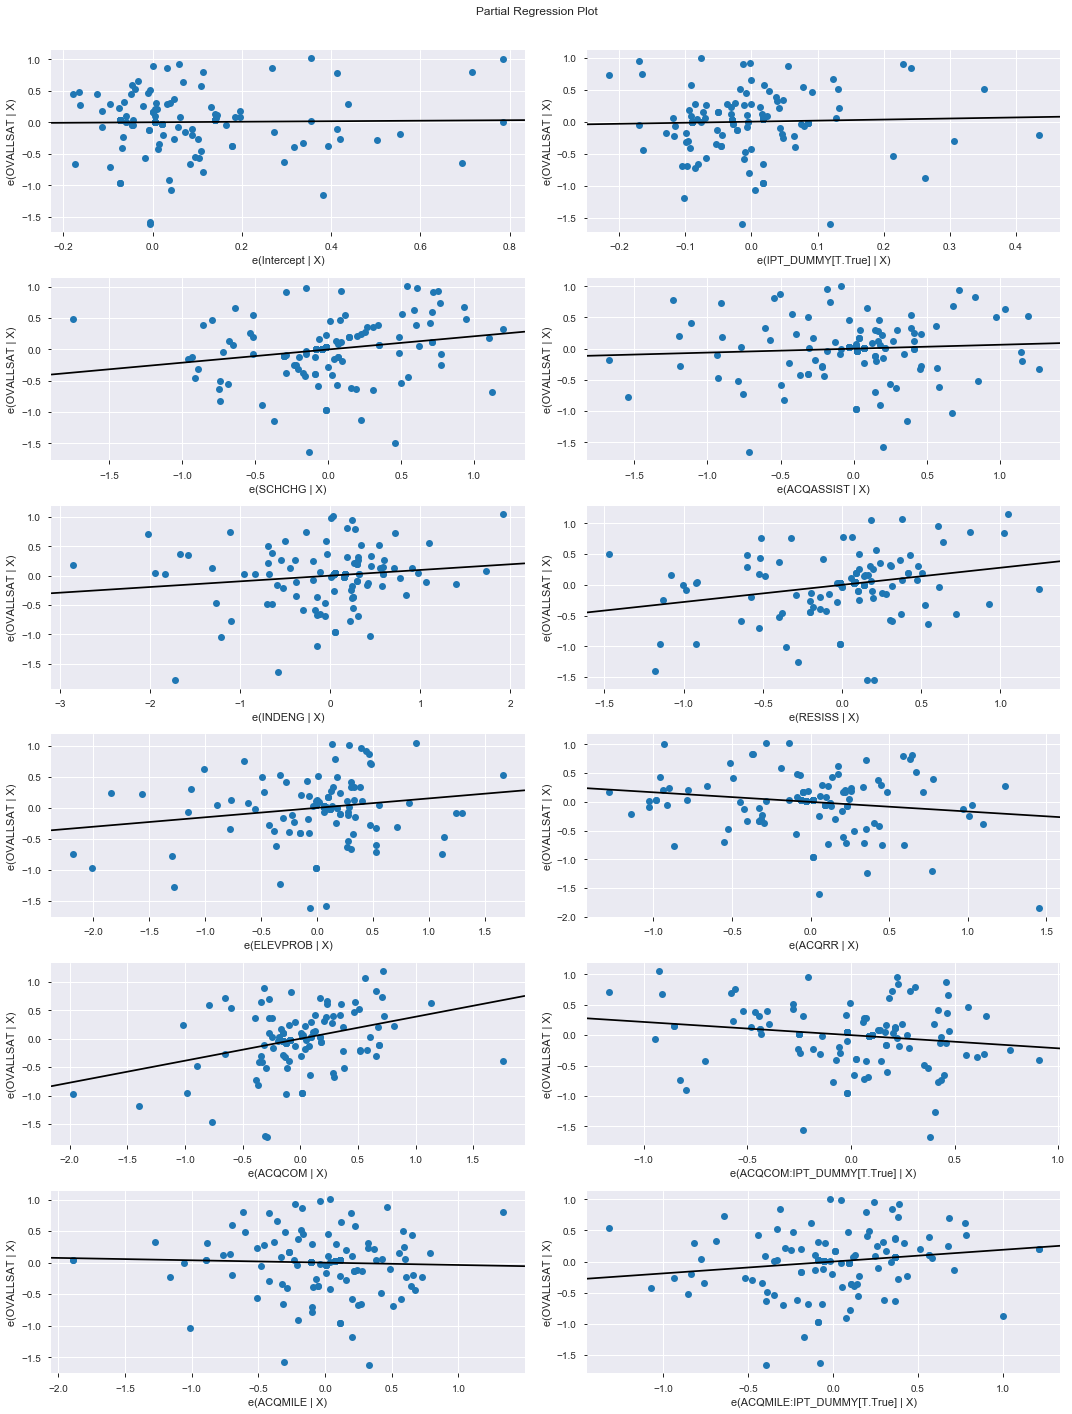

In [62]:
fig = plt.figure(figsize=(15,20))
fig = sm.graphics.plot_partregress_grid(wls, fig=fig)

## 1. Linearity
The dependent variable is assumed to be a linear function of the variables specified in the model. As such, our model  specification must be linear in its parameters. *Note that this does not mean that there must be a linear relationship between the independent and dependent variables.*

There are a few non-linearity tests we can run with `statsmodels`. We'll use the [Rainbow Test](https://www.tandfonline.com/doi/abs/10.1080/03610928208828423) for linearity, which has a null hypothesis that the regression is correctly modeled as linear.
>The basic idea of the Rainbow test is that even a misspecified model might fit (reasonably) well in the “center” of the sample while lacking fit in the tails. To test this, we fit the model to a subsample (typically, the middle 50%) and compare it to the full sample fit using an $F$ test. (We determine the “middle” by ordering by a regressor or by the Mahalanobis distance of the regressor vector $x_i$ to the mean regressor.) The null hypothesis is rejected whenever the overall fit is significantly worse than the fit for the subsample. The test statistic under $H_0$ follows an $F$ distribution with `n parameter` degrees of freedom. There's a good intuitive description of the test [here](https://stats.stackexchange.com/questions/137498/how-to-interpret-the-direction-of-the-harvey-collier-test-and-rainbow-test-for-l).

I'm expecting this assumption to be either violated or borderline due to all of our variables being ordinal and due to the results of the residuals-vs-fitted and observed-vs-fitted plots.

In [63]:
rainbow_test(ols)

fstat: 1.5035716578504208
p_value: 0.027454183347474088
This assumption is violated.


The rainbow test shows that the linearity assumption has been violated. Taken together with the diagnostic plots above, this is a problem because fitting a linear model to data which are nonlinearly/nonadditively related will likely result in inaccurate predictions, especially when we extrapolate beyond the range of the sample data.

## 2. Strict exogeneity
This means that, conditional on observing the data, the expectation of the error term is zero. That is, we want to know if the errors have a normal distribution conditional on the regressors: 
$$\varepsilon \mid X\sim \mathcal{N}(0, \sigma^2I_n)$$

>This is commonly violated with [omitted variable bias](https://en.wikipedia.org/wiki/Omitted-variable_bias), as the omitted independent variable is correlated with both the dependent variable and one (or more) of the included independent variables, causing a spurious model specification. (If this is suspected to be the case, we could use two-stage least squares (2SLS) regression, which requires finding an instrumental variable).

To assess this assumption, we can look at the QQ-plot we made earlier. The tails that fan out tell us that this assumption has been violated.

## 3. No multi-collinearity (or perfect collinearity)
Multicollinearity (so long as it is not "perfect") can be present and still result in an unbiased estimate. Even so, the estimates might be less precise and highly sensitive to particular sets of data and or model specifications. Specifically, multicollineariy has 5 major effects:

1. When predictor variables are correlated, the estimated regression coefficient of any one variable depends on which other predictor variables are included in the model. Depending on which predictors we included in the model, we can obtain (sometimes wildly) different estimates of the slope parameter for a given predictor.
2. When predictor variables are correlated, the precision of the estimated regression coefficients decreases as more predictor variables are added to the model.
3. When predictor variables are correlated, the marginal contribution of any one predictor variable in reducing the error sum of squares varies depending on which other variables are already in the model.
4. When predictor variables are correlated, hypothesis tests for $\beta_k = 0$ may yield different conclusions depending on which predictor variables are in the model. (This effect is a direct consequence of the three previous effects.)
5. High multicollinearity among predictor variables does not prevent good, precise predictions of the response within the scope of the model. If the primary purpose of your regression analysis is to estimate a mean response $\mu_Y$ or to predict a new response $y$, you don't have to worry much about multicollinearity.


#### The bottom line
In the presence of multicollinearity:

 - It is okay to use an estimated regression model to predict $y$ or estimate $\mu_Y$ as long as you do so within the scope of the model.
 - We can no longer make much sense of the usual interpretation of a slope coefficient as the change in the mean response for each additional unit increase in the predictor $x_k$, **when all the other predictors are held constant.** It just doesn't make sense to talk about holding the values of correlated predictors constant, since changing one predictor necessarily would change the values of the others.

Multicollinearity can be detected from the condition number or the variance inflation factor, among other tests. Here we'll look at the **variance inflation factor** for each regressor.

In [64]:
X = design_df[cols.values()].drop(labels = ['IPT_DUMMY', 'OVALLSAT'], axis = 1)
X_cols = list(X.columns)
X_cols.insert(0,'const')
X = X.values
#add columns of ones to represent a contsant for the OLS that statsmodels implements within variance_inflation_factor
X = sm.add_constant(X)
vifs = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
for col, vif in zip(X_cols, vifs):
    if col == 'const':
        continue
    print(f"{col} has vif of {vif}.")

ACQMILE has vif of 3.2641936181629725.
SCHCHG has vif of 5.743811470687627.
ACQASSIST has vif of 5.603519527149776.
INDENG has vif of 3.7975090136261804.
ACQCOM has vif of 6.5231520487462875.
RESISS has vif of 8.489678332708639.
ELEVPROB has vif of 5.83418496885111.
ACQRR has vif of 6.107235524337425.


A VIF value of 1 means that the predictor is not correlated with other variables. The higher the value, the greater the correlation of the variable with other variables (i.e. a great deal of the variance in that feature is explained by the remaining features). Values of more than 4 or 5 are sometimes regarded as being moderate to high, with values of 10 or more being regarded as very high. Our values are moderately high.

High VIFs are only a problem for the variables that are collinear. It increases the standard errors of their coefficients, and it may make those coefficients unstable in several ways. But so long as the collinear variables are only used as control variables, and they are not collinear with our variables of interest, there’s no problem in including them in a model. Unfortunately, `ACQCOM` is one of our variables of interest, and it's VIF is moderately high. 

To see the effect of these high VIFs, we'll specify different models and then inspect the impact the inclusion/exclusion of predictors has on the estimated coefficients, standard errors, and sequential sum of squares.

## 4. Spherical Errors
The error term (residuals) should have uniform variance (homoscedasticity) and no serial dependence (i.e. autocorrelation). Autocorrelation is a nonissue since this isn't time series data.

### Heteroscedasticity
Although there are heteroscedasticity tests to test the null hypothesis that all observations have the same error variance, i.e. errors are homoscedastic, we can just refer back to the Residuals-vs-Fitted plot and/or a Scale-Location plot to see if we have heteroscedasticity.

In those plots, we saw that the residuals began to spread wider along the x-axis as we passes around $4.5$, which is where the majority of the data falls. Thus we cannot say that there is no heteroscedasticity.

# Summary
There are two main issues with this analysis:
    
1. Inability to reproduce results
> Despite our model being specified the same as the original EViews analysis and including the same number of observations, we were not able to reproduce the results. Some of the coefficients even had their signs change (e.g. `ACQCOM:IPT_DUMMY[T.True]`.

2. Assumption Violations
>All of the assumptions have been violated to a certain degree. Our recommendation here would be to use a more suitable model given the data, such as ordered logistic regression or a decision tree.